### Imports

In [42]:
import random

import numpy as np
import pydub
import tensorflow as tf

In [12]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display

### 1. Start tensorflow and load model

In [2]:
sess = tf.Session()

In [36]:
full_model_dir = '/scratch0/ilya/locDoc/adv_audio_tf_board/spectrogram03.20.20/1584800014'

In [55]:
!cat /scratch0/ilya/locDoc/adv_audio_tf_board/spectrogram03.20.20/metalog.txt

datetime: 2020-03-21 10:13:34.522260
config: Namespace(batch_size=32, dropout=0.2, eval_period=5000, feature_height=256, hop_length=160, lr=0.0003, max_steps=10000000, model_root='/scratch0/ilya/locDoc/adv_audio_tf_board/spectrogram03.20.20', network_example_length=19840, tfrecord_example_length=80000, train_data_root='/scratch1/ilya/locDoc/data/alexa/v4e/train/', val_data_root='/scratch1/ilya/locDoc/data/alexa/v4e/val/', win_length=400)


In [133]:
# set some variables that are relavant to the network
network_example_length = 19840
hop_length = 160

In [37]:
tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], full_model_dir)
predictor = tf.contrib.predictor.from_saved_model(full_model_dir)

INFO:tensorflow:Restoring parameters from /scratch0/ilya/locDoc/adv_audio_tf_board/spectrogram03.20.20/1584800014/variables/variables
INFO:tensorflow:Restoring parameters from /scratch0/ilya/locDoc/adv_audio_tf_board/spectrogram03.20.20/1584800014/variables/variables


### Choice 2a: Load data from tfrecord

In [264]:
tfrecord_file = '/scratch0/ilya/locDownloads/v4e_5s_val_example.tfrecord'
spec_h = 256 # 80

In [472]:
examples = []
specs = []
spec_labs = []
limit = 100

for i, example in enumerate(tf.python_io.tf_record_iterator(tfrecord_file)):
    eg_np = tf.train.Example.FromString(example)
    audio_segment = pydub.AudioSegment(
        eg_np.features.feature["audio"].bytes_list.value[0], 
        frame_rate=16000,
        sample_width=2, 
        channels=1
    )
    y = audio_segment.get_array_of_samples()
    examples.append(y)

    spec = eg_np.features.feature["spectrogram"].float_list.value
    spec_labs.append(eg_np.features.feature["spectrogram_label"].int64_list.value)
    spec = np.array(spec).reshape(spec_h,-1)
    specs.append(spec)
    if i > limit:
        break

In [473]:
examples = np.array(examples)
specs = np.array(specs)

In [474]:
sound_i = random.randint(0,limit-1)
print(sound_i)
# in this tf record only even number examples contain alexa

53


In [475]:
# run this to guarantee alexa
if sound_i % 2 == 1:
    sound_i += 1
print(sound_i)

54


In [394]:
# run this to guarantee NOT alexa
if sound_i % 2 == 0:
    sound_i += 1 
print(sound_i)

5


In [476]:
ipd.Audio(examples[sound_i], rate=16000)

### Choice 2b: Load a wav file. Use data/record_audio_from_microphone.py

The audio is assumed to be 16kHz.
If you want to run Choice 2a after Choice 2b, you need to run all of the cells in Choice 2a again.

In [464]:
import glob
import soundfile as sf
from augment_audio import samples2spectrogam

In [465]:
myrecordings = glob.glob('/scratch0/ilya/locDownloads/ilya_voice_alexa/*.wav')

In [466]:
selection_i = 1
print(myrecordings[selection_i])
samples, _ = sf.read(myrecordings[selection_i])
examples = np.expand_dims(samples, 0)
sound_i = 0 # as a formality
ipd.Audio(examples[0], rate=16000)

/scratch0/ilya/locDownloads/ilya_voice_alexa/fan_positive_voice_recording.wav


In [467]:
specs = samples2spectrogam(samples, win_length=400, hop_length=hop_length, n_fft=512)
specs = np.expand_dims(specs,0)
# no labels formality
spec_labs = None
specs.shape

(1, 256, 500)

### 3. Transform data into network ready sizes

In [477]:
# break this long chunk into pieces and run each piece through the network
input_length = specs.shape[-1]
network_spec_length = network_example_length // hop_length
print(network_spec_length)
split_starts = np.arange(0, input_length - network_spec_length, dtype=int)
split_starts = split_starts[::20] # skip every nth = skip n*10ms
split_ends = (split_starts + network_spec_length).tolist()
split_starts = split_starts.tolist()
# add the last chunk
split_ends.append(input_length)
split_starts.append(input_length - network_spec_length)
sections = list(zip(split_starts, split_ends))
batched_input = []
for s, e in sections:
    batched_input.append(specs[sound_i,:,s:e])
batched_input = np.array(batched_input)
batched_input.shape

124


(20, 256, 124)

### 4. Put data through network

In [478]:
masks = predictor({"spectrograms": batched_input })['output']
masks.shape

(20, 62)

### 5. Splice together the chunked network outputs

Note that the network output is smaller than the input in time dimension. c.f. Guo for why.

In [479]:
aggregated_mask = np.zeros(input_length)
n_times_aggregated = np.zeros(input_length, dtype=int)
for i, section in enumerate(sections):
    s, e = section
    aggregated_mask[s:e:2] += masks[i]
    n_times_aggregated[s:e:2] += 1
    # expansion
    aggregated_mask[(s+1):e:2] += masks[i]
    n_times_aggregated[(s+1):e:2] += 1
mean_mask = aggregated_mask / n_times_aggregated

Exponential smoothing filter
This filter is applied to the `mean_mask`. Which has 1 bin
for every hop size (10ms). So if below N=90 it looks back 90ms

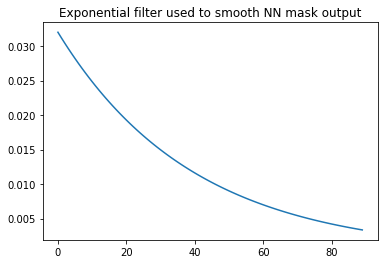

In [487]:
alpha = 0.025
N = 90
myfilt = alpha*((1-alpha)**np.arange(0,N))
myfilt /= myfilt[:60].sum()


smoothed_mask = np.correlate(np.array(mean_mask), myfilt, 'same')
plt.title('Exponential filter used to smooth NN mask output')
plt.plot(myfilt)

Visualize the mask

Text(0.5, 1.0, 'Wakeword detection masks for loaded audio')

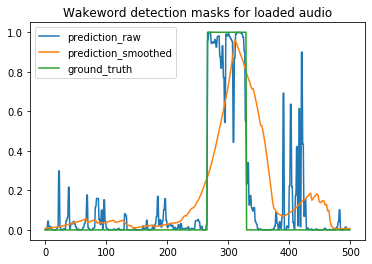

In [489]:
plt.plot(mean_mask)
plt.plot(smoothed_mask)
mylegend = ['prediction_raw', 'prediction_smoothed']
if spec_labs is not None:
    plt.plot(spec_labs[sound_i])
    mylegend.append('ground_truth')
plt.legend(mylegend)
plt.title('Wakeword detection masks for loaded audio')

Play the sound with a beep inserted when "alexa" is detected in the smoothed prediction above the following threshold

In [482]:
# setting this changes MR and FAR
# and obviously it is dependent on the smoothing filter above
detection_threshold = 0.5

In [483]:
# make a half second beep
len_beep = 4000
t = np.arange(len_beep)
amplitude = examples[sound_i].max() * 0.8
beep = amplitude * np.sin(t * 440*2*np.pi/(16000)) # 440Hz beep

In [490]:
detected_ever = (smoothed_mask > detection_threshold).sum()
sound_with_beep = examples[sound_i].copy().astype(float)
if detected_ever:
    first_detected_bin = (smoothed_mask > detection_threshold).tolist().index(True)
    sound_idx = int(float(first_detected_bin) / len(smoothed_mask) * len(examples[sound_i]))

    sound_with_beep[sound_idx:(sound_idx+len_beep)] += beep
    sound_with_beep[sound_idx:(sound_idx+len_beep)] = sound_with_beep[sound_idx:(sound_idx+len_beep)] / 2
    print('Detected Wakeword %.2fs in the clip' % (sound_idx/16000.0))
else:
    print('Never detected Wakeword')

Detected Wakeword 2.85s in the clip


In [485]:
ipd.Audio(sound_with_beep, rate=16000)